Device: cuda
n_features: 10 | train/val/test: 5938 659 1650
train end date: 2018-01-23 00:00:00 | test start date: 2018-01-24 00:00:00
Epoch 10/100 | VAL=0.001807
Epoch 20/100 | VAL=0.000955
Epoch 30/100 | VAL=0.000795
Epoch 40/100 | VAL=0.000494
Epoch 50/100 | VAL=0.000544
Epoch 60/100 | VAL=0.000535
Early stop @ 61 | best VAL=0.000357
[TEST one-step] RMSE: 0.1007 | MAE: 0.0878 | R2: 0.9905


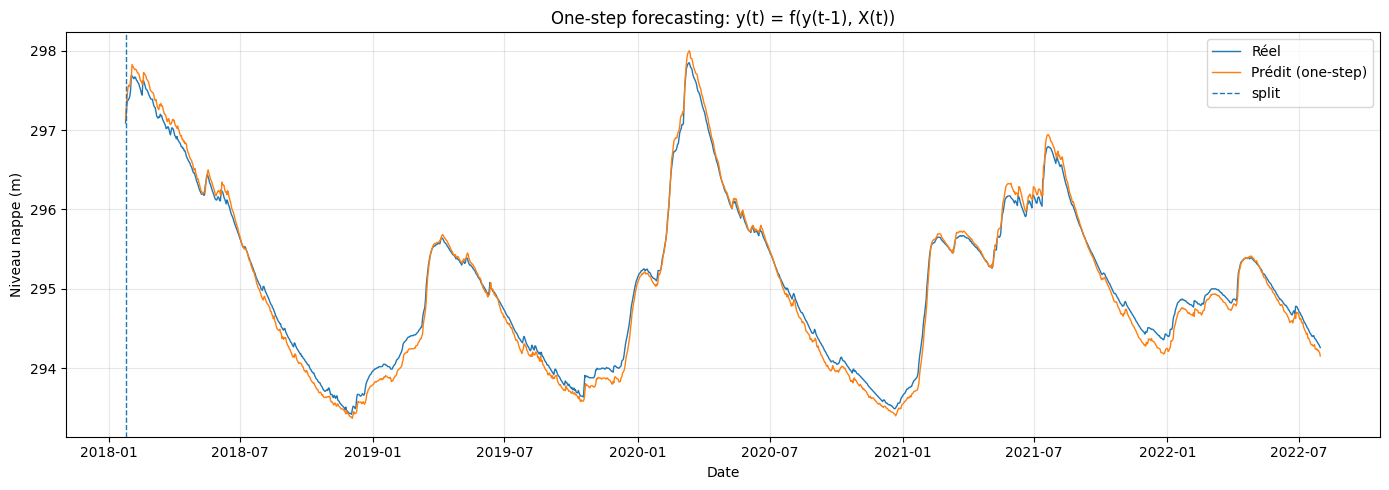

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =========================
# Config
# =========================
PIEZO_FILE = "dataset/time_series/piezos/BSS001CVLZ.csv"
FORCAGE_FILE = "dataset/time_series/forçages/A146020302.txt"

TRAIN_RATIO_RAW = 0.8
VAL_RATIO_IN_TRAIN = 0.1

# One-step setup
SEQUENCE_LENGTH = 1     # on donne UNE "ligne" par jour (pas 30 jours)
FORECAST_HORIZON = 1    # on prédit y(t) uniquement

# Transformer params (tu peux réduire, mais je garde proche de ton code)
D_MODEL = 64
N_HEAD = 4
NUM_LAYERS = 2
DIM_FF = 128
DROPOUT = 0.2

LEARNING_RATE = 1e-3
EPOCHS = 100
BATCH_SIZE = 128
WEIGHT_DECAY = 1e-4
GRAD_CLIP = 1.0
PATIENCE_EARLYSTOP = 15

base_features = ['Ptot', 'Temp', 'E_PM', 'Humi', 'Vent', 'IHGR', 'SWI']
target = 'niveau_nappe_eau'

USE_DOY_ENCODING = True  # sin/cos day-of-year

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# =========================
# Load & preprocess
# =========================
df_piezo = pd.read_csv(PIEZO_FILE)
df_piezo['date'] = pd.to_datetime(df_piezo['date_mesure'])
df_piezo = df_piezo[['date', target]].set_index('date')

df_forcage = pd.read_csv(FORCAGE_FILE, sep=';', comment='#', skipinitialspace=True)
df_forcage.columns = df_forcage.columns.str.strip()
df_forcage['date'] = pd.to_datetime(df_forcage['Date'], format='%Y%m%d')
df_forcage = df_forcage.set_index('date')[base_features]

df = df_piezo.join(df_forcage, how='inner')
df = df[df.index >= '2000-01-01']
df = df.resample('D').mean().interpolate(limit_direction='both')
df = df.replace(-99, np.nan).interpolate(limit_direction='both').dropna()

# y_prev = niveau de la veille (ce que tu veux passer au modèle)
df["y_prev"] = df[target].shift(1)

features = list(base_features) + ["y_prev"]

if USE_DOY_ENCODING:
    doy = df.index.dayofyear.values.astype(np.float32)
    df["doy_sin"] = np.sin(2 * np.pi * doy / 365.25)
    df["doy_cos"] = np.cos(2 * np.pi * doy / 365.25)
    features += ["doy_sin", "doy_cos"]

df = df.dropna()

# =========================
# Dataset one-step: X(t) = [exog(t), y_prev(t), doy(t)] -> y(t)
# =========================
X_raw = df[features].values.astype(np.float32)          # (N, nfeat)
y_raw = df[[target]].values.astype(np.float32)          # (N, 1)

split_raw = int(len(df) * TRAIN_RATIO_RAW)
split_raw = max(split_raw, 10)  # sécurité

# Scalers TRAIN only (no leakage)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
scaler_X.fit(X_raw[:split_raw])
scaler_y.fit(y_raw[:split_raw])

X_scaled = scaler_X.transform(X_raw).astype(np.float32)
y_scaled = scaler_y.transform(y_raw).astype(np.float32)

# On transforme en "séquences" de longueur 1 pour garder ton Transformer inchangé
# X_seq: (N, 1, nfeat) ; y_seq: (N, 1)
X_seq = X_scaled.reshape(-1, 1, X_scaled.shape[1])
y_seq = y_scaled.reshape(-1, 1)  # (N,1)

# Split chrono en train/test
X_train_full, y_train_full = X_seq[:split_raw], y_seq[:split_raw]
X_test, y_test = X_seq[split_raw:], y_seq[split_raw:]

# Val = fin du train
val_size = max(1, int(len(X_train_full) * VAL_RATIO_IN_TRAIN))
X_train, y_train = X_train_full[:-val_size], y_train_full[:-val_size]
X_val, y_val     = X_train_full[-val_size:], y_train_full[-val_size:]

# =========================
# Model
# =========================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=32):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        return self.dropout(x + self.pe[:, :x.size(1), :])

class TransformerOneStep(nn.Module):
    def __init__(self, input_size, d_model, n_head, num_layers, dim_ff, dropout=0.2):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, dropout=dropout, max_len=32)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_head,
            dim_feedforward=dim_ff,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        # sortie 1 valeur : y(t)
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1)
        )

    def forward(self, x):
        # x: (batch, 1, nfeat)
        z = self.encoder(self.pos_enc(self.input_proj(x)))
        last = z[:, -1, :]
        return self.head(last)  # (batch, 1)

model = TransformerOneStep(
    input_size=len(features),
    d_model=D_MODEL,
    n_head=N_HEAD,
    num_layers=NUM_LAYERS,
    dim_ff=DIM_FF,
    dropout=DROPOUT
).to(device)

# =========================
# Train
# =========================
X_train_t = torch.from_numpy(X_train).to(device)
y_train_t = torch.from_numpy(y_train).to(device)
X_val_t   = torch.from_numpy(X_val).to(device)
y_val_t   = torch.from_numpy(y_val).to(device)
X_test_t  = torch.from_numpy(X_test).to(device)
y_test_t  = torch.from_numpy(y_test).to(device)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH_SIZE, shuffle=True)

crit = nn.MSELoss()
opt = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=10, factor=0.5)

best_val = float("inf")
bad = 0

print("n_features:", len(features), "| train/val/test:", len(X_train), len(X_val), len(X_test))
print("train end date:", df.index[split_raw-1], "| test start date:", df.index[split_raw])

for epoch in range(EPOCHS):
    model.train()
    for xb, yb in train_loader:
        opt.zero_grad(set_to_none=True)
        pred = model(xb)
        loss = crit(pred, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        opt.step()

    model.eval()
    with torch.no_grad():
        val_loss = crit(model(X_val_t), y_val_t).item()

    sched.step(val_loss)

    if val_loss < best_val - 1e-9:
        best_val = val_loss
        bad = 0
        torch.save(model.state_dict(), "best_tf_onestep.pth")
    else:
        bad += 1

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | VAL={val_loss:.6f}")

    if bad >= PATIENCE_EARLYSTOP:
        print(f"Early stop @ {epoch+1} | best VAL={best_val:.6f}")
        break

model.load_state_dict(torch.load("best_tf_onestep.pth", map_location=device))

# =========================
# Evaluation one-step on TEST
# =========================
model.eval()
with torch.no_grad():
    pred_test_s = model(X_test_t).cpu().numpy()  # scaled (N,1)

pred_test = scaler_y.inverse_transform(pred_test_s).flatten()
true_test = y_raw[split_raw:].flatten()

rmse = np.sqrt(mean_squared_error(true_test, pred_test))
mae  = mean_absolute_error(true_test, pred_test)
r2   = r2_score(true_test, pred_test)
print(f"[TEST one-step] RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")

# =========================
# Inference: prédire UN jour
# Tu passes: y_prev (réel) + forçages du jour t
# =========================
def predict_one_day(y_prev: float, x_today: dict, date=None) -> float:
    """
    x_today doit contenir les clés base_features: Ptot, Temp, E_PM, Humi, Vent, IHGR, SWI
    y_prev = niveau nappe du jour précédent (réel)
    date (optionnel) = "YYYY-MM-DD" ou Timestamp pour calculer doy
    """
    if USE_DOY_ENCODING and date is not None:
        d = pd.to_datetime(date)
        doy = float(d.dayofyear)
        doy_sin = float(np.sin(2*np.pi*doy/365.25))
        doy_cos = float(np.cos(2*np.pi*doy/365.25))
    elif USE_DOY_ENCODING:
        doy_sin, doy_cos = 0.0, 0.0

    row = [float(x_today[k]) for k in base_features] + [float(y_prev)]
    if USE_DOY_ENCODING:
        row += [doy_sin, doy_cos]

    row = np.array(row, dtype=np.float32).reshape(1, -1)        # (1,nfeat)
    row_s = scaler_X.transform(row).astype(np.float32)          # scaled
    x = torch.from_numpy(row_s).reshape(1, 1, -1).to(device)    # (1,1,nfeat)

    model.eval()
    with torch.no_grad():
        y_s = model(x).cpu().numpy()                            # (1,1) scaled

    y_hat = scaler_y.inverse_transform(y_s)[0, 0]
    return float(y_hat)

# Plot (one-step)
plt.figure(figsize=(14, 5))
plt.plot(df.index[split_raw:], true_test, linewidth=1, label="Réel")
plt.plot(df.index[split_raw:], pred_test, linewidth=1, label="Prédit (one-step)")
plt.axvline(df.index[split_raw], linestyle="--", linewidth=1, label="split")
plt.xlabel("Date")
plt.ylabel("Niveau nappe (m)")
plt.title("One-step forecasting: y(t) = f(y(t-1), X(t))")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


[ROLLING AUTONOME one-step] RMSE: 1.5542 | MAE: 1.3271 | R2: -1.2597


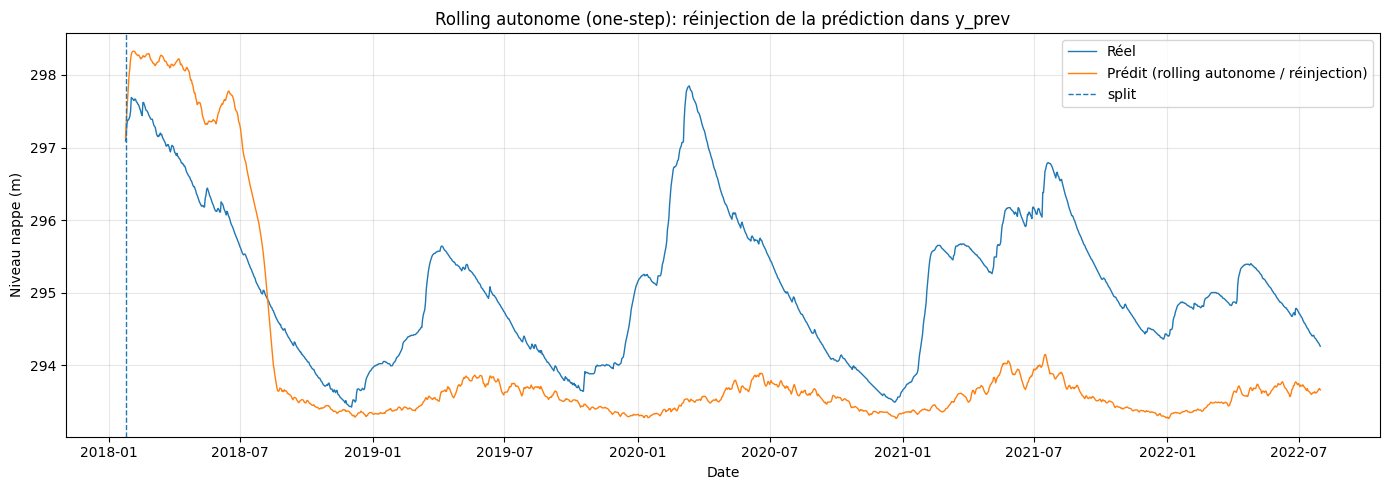

In [17]:
# =========================
# Test rolling AUTONOME (réinjection de y_prev = y_hat)
# =========================

# On va prédire toute la zone TEST (à partir de split_raw)
# en réinjectant la prédiction comme y_prev pour le jour suivant.

model.eval()

# dates test
test_dates = df.index[split_raw:]

# vrai y sur test (pour comparer)
y_true_test = df[target].iloc[split_raw:].values.astype(np.float32)

# buffer prédictions
y_pred_roll = np.zeros(len(test_dates), dtype=np.float32)

# initialisation : y_prev réel = dernier jour de train
y_prev = float(df[target].iloc[split_raw - 1])

for i, d in enumerate(test_dates):
    # forçages du jour d (connus)
    x_today = {k: float(df[k].loc[d]) for k in base_features}

    # prédiction du jour
    y_hat = predict_one_day(y_prev=y_prev, x_today=x_today, date=d)

    y_pred_roll[i] = y_hat

    # réinjection pour le jour suivant
    y_prev = y_hat


# =========================
# Metrics rolling autonome
# =========================
rmse_roll = np.sqrt(mean_squared_error(y_true_test, y_pred_roll))
mae_roll  = mean_absolute_error(y_true_test, y_pred_roll)
r2_roll   = r2_score(y_true_test, y_pred_roll)

print(f"[ROLLING AUTONOME one-step] RMSE: {rmse_roll:.4f} | MAE: {mae_roll:.4f} | R2: {r2_roll:.4f}")


# =========================
# Plot
# =========================
plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_true_test, linewidth=1, label="Réel")
plt.plot(test_dates, y_pred_roll, linewidth=1, label="Prédit (rolling autonome / réinjection)")
plt.axvline(df.index[split_raw], linestyle="--", linewidth=1, label="split")
plt.xlabel("Date")
plt.ylabel("Niveau nappe (m)")
plt.title("Rolling autonome (one-step): réinjection de la prédiction dans y_prev")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Device: cuda
n_features: 9 | seq_len: 30
train/val/test: 5913 656 1650
train end date: 2018-01-23 00:00:00 | test start date: 2018-01-24 00:00:00


/opt/venvs/deepeirb/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 10/100 | VAL=0.030447
Epoch 20/100 | VAL=0.029728
Early stop @ 23 | best VAL=0.028844
[TEST exog-only] RMSE: 0.6354 | MAE: 0.5088 | R2: 0.6223


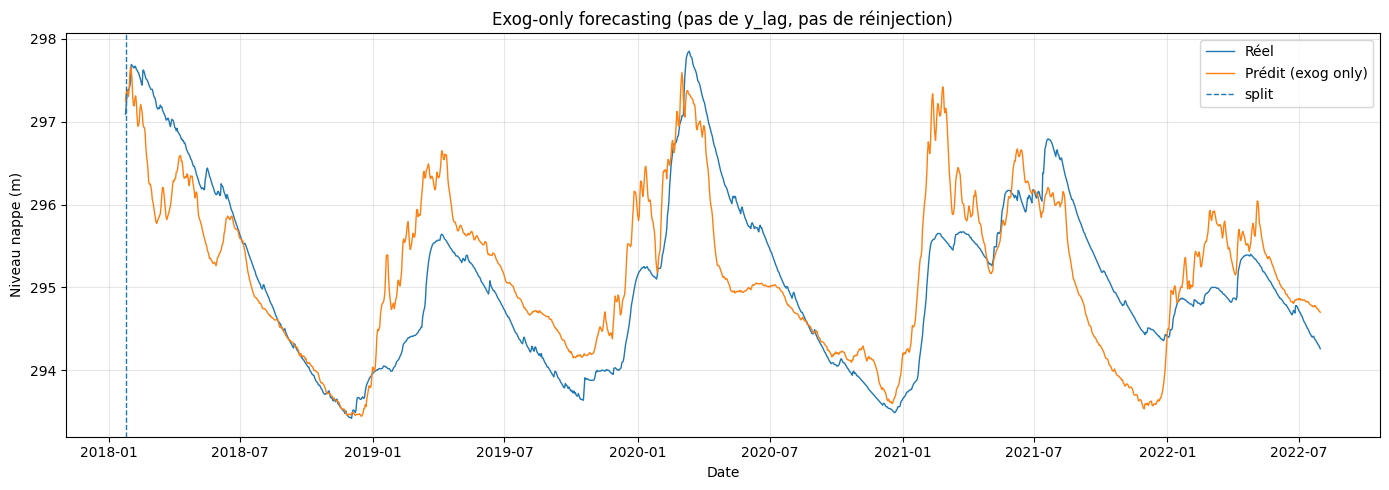

In [15]:
# =========================
# Config
# =========================
PIEZO_FILE = "dataset/time_series/piezos/BSS001CVLZ.csv"
FORCAGE_FILE = "dataset/time_series/forçages/A146020302.txt"

SEQUENCE_LENGTH = 30     # fenêtre passée (exog only)
FORECAST_HORIZON = 1     # y(t) uniquement

D_MODEL = 64
N_HEAD = 4
NUM_LAYERS = 2
DIM_FF = 128
DROPOUT = 0.2

LEARNING_RATE = 1e-3
EPOCHS = 100
BATCH_SIZE = 64
WEIGHT_DECAY = 1e-4
GRAD_CLIP = 1.0
PATIENCE_EARLYSTOP = 15

TRAIN_RATIO_RAW = 0.8
VAL_RATIO_IN_TRAIN = 0.1

base_features = ['Ptot', 'Temp', 'E_PM', 'Humi', 'Vent', 'IHGR', 'SWI']
target = 'niveau_nappe_eau'
USE_DOY_ENCODING = True

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# =========================
# Load & preprocess
# =========================
df_piezo = pd.read_csv(PIEZO_FILE)
df_piezo['date'] = pd.to_datetime(df_piezo['date_mesure'])
df_piezo = df_piezo[['date', target]].set_index('date')

df_forcage = pd.read_csv(FORCAGE_FILE, sep=';', comment='#', skipinitialspace=True)
df_forcage.columns = df_forcage.columns.str.strip()
df_forcage['date'] = pd.to_datetime(df_forcage['Date'], format='%Y%m%d')
df_forcage = df_forcage.set_index('date')[base_features]

df = df_piezo.join(df_forcage, how='inner')
df = df[df.index >= '2000-01-01']
df = df.resample('D').mean().interpolate(limit_direction='both')
df = df.replace(-99, np.nan).interpolate(limit_direction='both').dropna()

features = list(base_features)

if USE_DOY_ENCODING:
    doy = df.index.dayofyear.values.astype(np.float32)
    df["doy_sin"] = np.sin(2 * np.pi * doy / 365.25)
    df["doy_cos"] = np.cos(2 * np.pi * doy / 365.25)
    features += ["doy_sin", "doy_cos"]

df = df.dropna()

# =========================
# Build sequences: X(t-seq_len+1..t) -> y(t)
# =========================
X_raw = df[features].values.astype(np.float32)
y_raw = df[[target]].values.astype(np.float32)

def create_seq_exog_to_yt(X, y, seq_len):
    Xs, ys = [], []
    for t in range(seq_len - 1, len(X)):
        Xs.append(X[t - seq_len + 1 : t + 1])  # (seq_len, nfeat)
        ys.append(y[t])                        # (1,)
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)

X_seq_raw, y_seq_raw = create_seq_exog_to_yt(X_raw, y_raw, SEQUENCE_LENGTH)

# chrono split en RAW (attention: X_seq_raw commence à t=seq_len-1)
# On split sur df, donc on déduit l'index correspondant dans les séquences:
split_raw = int(len(df) * TRAIN_RATIO_RAW)
split_raw = max(split_raw, SEQUENCE_LENGTH + 1)

# index séquence correspondant au split_raw-1
# car la séquence i cible y au temps t = i + (seq_len-1)
split_seq = split_raw - (SEQUENCE_LENGTH - 1)
split_seq = max(split_seq, 1)

X_train_raw, y_train_raw = X_seq_raw[:split_seq], y_seq_raw[:split_seq]
X_test_raw,  y_test_raw  = X_seq_raw[split_seq:], y_seq_raw[split_seq:]

# scalers fit TRAIN only
scX = MinMaxScaler()
scy = MinMaxScaler()

# pour scaler_X: on fit sur toutes les lignes (flatten) du train
scX.fit(X_train_raw.reshape(-1, X_train_raw.shape[-1]))
scy.fit(y_train_raw)

X_train = scX.transform(X_train_raw.reshape(-1, X_train_raw.shape[-1])).reshape(X_train_raw.shape).astype(np.float32)
X_test  = scX.transform(X_test_raw.reshape(-1, X_test_raw.shape[-1])).reshape(X_test_raw.shape).astype(np.float32)
y_train = scy.transform(y_train_raw).astype(np.float32)
y_test  = scy.transform(y_test_raw).astype(np.float32)

# val = fin du train
val_size = max(1, int(len(X_train) * VAL_RATIO_IN_TRAIN))
X_tr, y_tr = X_train[:-val_size], y_train[:-val_size]
X_val, y_val = X_train[-val_size:], y_train[-val_size:]

# =========================
# Model
# =========================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        return self.dropout(x + self.pe[:, :x.size(1), :])

class TransformerExogToY(nn.Module):
    def __init__(self, input_size, d_model, n_head, num_layers, dim_ff, dropout=0.2):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, dropout=dropout, max_len=SEQUENCE_LENGTH + 5)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_head,
            dim_feedforward=dim_ff,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1)
        )

    def forward(self, x):
        # x: (batch, seq_len, nfeat)
        z = self.encoder(self.pos_enc(self.input_proj(x)))
        last = z[:, -1, :]
        return self.head(last)  # (batch,1)

model = TransformerExogToY(
    input_size=len(features),
    d_model=D_MODEL,
    n_head=N_HEAD,
    num_layers=NUM_LAYERS,
    dim_ff=DIM_FF,
    dropout=DROPOUT
).to(device)

crit = nn.MSELoss()
opt = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=10, factor=0.5)

# tensors
X_tr_t  = torch.from_numpy(X_tr).to(device)
y_tr_t  = torch.from_numpy(y_tr).to(device)
X_val_t = torch.from_numpy(X_val).to(device)
y_val_t = torch.from_numpy(y_val).to(device)
X_test_t = torch.from_numpy(X_test).to(device)
y_test_t = torch.from_numpy(y_test).to(device)

train_loader = DataLoader(TensorDataset(X_tr_t, y_tr_t), batch_size=BATCH_SIZE, shuffle=True)

best, bad = float("inf"), 0

print("n_features:", len(features), "| seq_len:", SEQUENCE_LENGTH)
print("train/val/test:", len(X_tr), len(X_val), len(X_test))
print("train end date:", df.index[split_raw-1], "| test start date:", df.index[split_raw])

for epoch in range(EPOCHS):
    model.train()
    for xb, yb in train_loader:
        opt.zero_grad(set_to_none=True)
        pred = model(xb)
        loss = crit(pred, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        opt.step()

    model.eval()
    with torch.no_grad():
        val_loss = crit(model(X_val_t), y_val_t).item()

    sched.step(val_loss)

    if val_loss < best - 1e-9:
        best, bad = val_loss, 0
        torch.save(model.state_dict(), "best_tf_exog_only.pth")
    else:
        bad += 1

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | VAL={val_loss:.6f}")

    if bad >= PATIENCE_EARLYSTOP:
        print(f"Early stop @ {epoch+1} | best VAL={best:.6f}")
        break

model.load_state_dict(torch.load("best_tf_exog_only.pth", map_location=device))

# =========================
# Eval on TEST
# =========================
model.eval()
with torch.no_grad():
    pred_s = model(X_test_t).cpu().numpy()  # scaled

pred = scy.inverse_transform(pred_s).flatten()
true = y_test_raw.flatten()

rmse = np.sqrt(mean_squared_error(true, pred))
mae  = mean_absolute_error(true, pred)
r2   = r2_score(true, pred)
print(f"[TEST exog-only] RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")

# dates test (alignement)
# y_test_raw correspond aux dates df à partir de t = (SEQUENCE_LENGTH-1)+split_seq
test_start_t = (SEQUENCE_LENGTH - 1) + split_seq
dates_test = df.index[test_start_t:]

plt.figure(figsize=(14,5))
plt.plot(dates_test, true, linewidth=1, label="Réel")
plt.plot(dates_test, pred, linewidth=1, label="Prédit (exog only)")
plt.axvline(df.index[split_raw], linestyle="--", linewidth=1, label="split")
plt.title("Exog-only forecasting (pas de y_lag, pas de réinjection)")
plt.xlabel("Date")
plt.ylabel("Niveau nappe (m)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Device: cuda
train end date: 2018-01-23 00:00:00 | test start date: 2018-01-24 00:00:00


/opt/venvs/deepeirb/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 10/100 | VAL=0.009000
Epoch 20/100 | VAL=0.005868
Epoch 30/100 | VAL=0.005304
Epoch 40/100 | VAL=0.004391
Epoch 50/100 | VAL=0.005113
Epoch 60/100 | VAL=0.008035
Early stop @ 61 | best VAL=0.003983
[TEST teacher-forced] RMSE: 0.0868 | MAE: 0.0662 | R2: 0.9930


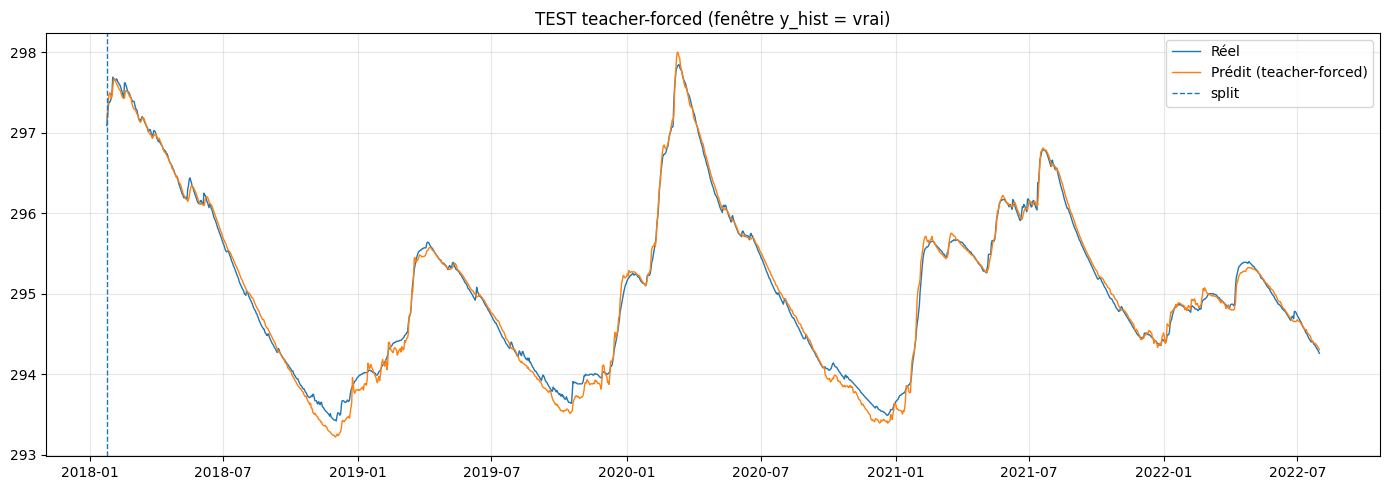

In [16]:
# =========================
# Config
# =========================
PIEZO_FILE = "dataset/time_series/piezos/BSS001CVLZ.csv"
FORCAGE_FILE = "dataset/time_series/forçages/A146020302.txt"

TRAIN_RATIO_RAW = 0.8
VAL_RATIO_IN_TRAIN = 0.1

Y_WINDOW = 30             # 30 jours de y passés
FORECAST_HORIZON = 1       # y(t)

D_MODEL = 64
N_HEAD = 4
NUM_LAYERS = 2
DIM_FF = 128
DROPOUT = 0.2

LEARNING_RATE = 1e-3
EPOCHS = 100
BATCH_SIZE = 128
WEIGHT_DECAY = 1e-4
GRAD_CLIP = 1.0
PATIENCE_EARLYSTOP = 15

base_features = ['Ptot', 'Temp', 'E_PM', 'Humi', 'Vent', 'IHGR', 'SWI']
target = 'niveau_nappe_eau'
USE_DOY_ENCODING = True

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# =========================
# Load & preprocess
# =========================
df_piezo = pd.read_csv(PIEZO_FILE)
df_piezo["date"] = pd.to_datetime(df_piezo["date_mesure"])
df_piezo = df_piezo[["date", target]].set_index("date")

df_forcage = pd.read_csv(FORCAGE_FILE, sep=";", comment="#", skipinitialspace=True)
df_forcage.columns = df_forcage.columns.str.strip()
df_forcage["date"] = pd.to_datetime(df_forcage["Date"], format="%Y%m%d")
df_forcage = df_forcage.set_index("date")[base_features]

df = df_piezo.join(df_forcage, how="inner")
df = df[df.index >= "2000-01-01"]
df = df.resample("D").mean().interpolate(limit_direction="both")
df = df.replace(-99, np.nan).interpolate(limit_direction="both").dropna()

# Temps (saison)
if USE_DOY_ENCODING:
    doy = df.index.dayofyear.values.astype(np.float32)
    df["doy_sin"] = np.sin(2*np.pi*doy/365.25)
    df["doy_cos"] = np.cos(2*np.pi*doy/365.25)

# =========================
# Dataset builder
# =========================
# X_model(t) = [X(t), doy(t)] et Y_hist = [y(t-30)..y(t-1)]
# On construit une séquence de longueur (Y_WINDOW + 1):
# tokens 0..29 : y_hist (1 feature)
# token 30     : x_today (n_features)
#
# => input_size = 1 pour tokens y, et input_size = n_exog pour token exog
# Pour simplifier: on concatène tout en même dimension en padding:
# - y tokens -> vecteur de dim = n_in avec y dans une colonne dédiée
# - exog token -> vecteur de dim = n_in avec exogs dans leurs colonnes
#
# n_in = 1 (y) + n_exog
# y tokens: [y, 0,0,0...]
# exog token: [0, exogs...]
#
# Sortie = y(t)

exog_features = list(base_features)
if USE_DOY_ENCODING:
    exog_features += ["doy_sin", "doy_cos"]

N_EXOG = len(exog_features)
N_IN = 1 + N_EXOG  # [y] + [exogs...]

def build_samples(df: pd.DataFrame, y_window: int):
    X_list, y_list, date_list = [], [], []
    y_arr = df[target].values.astype(np.float32)
    exog_arr = df[exog_features].values.astype(np.float32)

    for t in range(y_window, len(df)):
        y_hist = y_arr[t-y_window:t]          # (30,)
        x_t = exog_arr[t]                     # (N_EXOG,)
        y_t = y_arr[t]                        # scalar

        # tokens (y_window + 1, N_IN)
        seq = np.zeros((y_window + 1, N_IN), dtype=np.float32)

        # tokens y_hist
        seq[:y_window, 0] = y_hist  # colonne y

        # token exog du jour t
        seq[y_window, 1:] = x_t     # colonnes exog

        X_list.append(seq)
        y_list.append(y_t)
        date_list.append(df.index[t])

    return np.array(X_list), np.array(y_list).reshape(-1, 1), np.array(date_list)

X_raw, y_raw, dates = build_samples(df, Y_WINDOW)

# =========================
# Split chrono
# =========================
# split_raw est index dans df; nos samples commencent à t=Y_WINDOW
# sample i correspond à date df.index[t=Y_WINDOW+i]
split_raw = int(len(df) * TRAIN_RATIO_RAW)
split_raw = max(split_raw, Y_WINDOW + 10)

split_idx = split_raw - Y_WINDOW  # index dans X_raw
split_idx = max(1, min(split_idx, len(X_raw)-1))

X_train_raw, y_train_raw = X_raw[:split_idx], y_raw[:split_idx]
X_test_raw,  y_test_raw  = X_raw[split_idx:], y_raw[split_idx:]
dates_test = dates[split_idx:]

# =========================
# Scaling (TRAIN only)
# =========================
# On scale la colonne y (dans tokens y_hist) et les exogs séparément
sc_y = StandardScaler()
sc_x = StandardScaler()

# Fit y scaler sur y(t) train (ou sur tous y_hist train, les deux marchent)
sc_y.fit(y_train_raw)

# Fit exog scaler sur exogs train (token exog uniquement)
exog_train = X_train_raw[:, -1, 1:]  # (Ntrain, N_EXOG)
sc_x.fit(exog_train)

def transform_inputs(X):
    X2 = X.copy()
    # scale y_hist column 0 using sc_y
    y_hist_vals = X2[:, :-1, 0].reshape(-1, 1)          # all y tokens
    y_hist_vals = sc_y.transform(y_hist_vals)
    X2[:, :-1, 0] = y_hist_vals.reshape(X2.shape[0], -1)

    # scale exog token cols 1:
    X2[:, -1, 1:] = sc_x.transform(X2[:, -1, 1:])
    return X2.astype(np.float32)

def transform_target(y):
    return sc_y.transform(y).astype(np.float32)

X_train = transform_inputs(X_train_raw)
X_test  = transform_inputs(X_test_raw)
y_train = transform_target(y_train_raw)
y_test  = transform_target(y_test_raw)

# val = fin du train
val_size = max(1, int(len(X_train) * VAL_RATIO_IN_TRAIN))
X_tr, y_tr = X_train[:-val_size], y_train[:-val_size]
X_val, y_val = X_train[-val_size:], y_train[-val_size:]

# =========================
# Model
# =========================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=512):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        return self.dropout(x + self.pe[:, :x.size(1), :])

class TransformerAR(nn.Module):
    def __init__(self, input_size, d_model, n_head, num_layers, dim_ff, dropout=0.2):
        super().__init__()
        self.in_proj = nn.Linear(input_size, d_model)
        self.pos = PositionalEncoding(d_model, dropout=dropout, max_len=Y_WINDOW+2)

        enc = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_head, dim_feedforward=dim_ff,
            dropout=dropout, batch_first=True, activation="gelu", norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model//2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, 1)
        )

    def forward(self, x):
        # x: (B, y_window+1, N_IN)
        z = self.encoder(self.pos(self.in_proj(x)))
        last = z[:, -1, :]       # token exog day
        return self.head(last)   # (B,1) scaled y

model = TransformerAR(N_IN, D_MODEL, N_HEAD, NUM_LAYERS, DIM_FF, DROPOUT).to(device)

# =========================
# Train
# =========================
X_tr_t = torch.from_numpy(X_tr).to(device)
y_tr_t = torch.from_numpy(y_tr).to(device)
X_val_t = torch.from_numpy(X_val).to(device)
y_val_t = torch.from_numpy(y_val).to(device)

train_loader = DataLoader(TensorDataset(X_tr_t, y_tr_t), batch_size=BATCH_SIZE, shuffle=True)

crit = nn.MSELoss()
opt = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=10, factor=0.5)

best, bad = float("inf"), 0

print("train end date:", df.index[split_raw-1], "| test start date:", df.index[split_raw])

for epoch in range(EPOCHS):
    model.train()
    for xb, yb in train_loader:
        opt.zero_grad(set_to_none=True)
        pred = model(xb)
        loss = crit(pred, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        opt.step()

    model.eval()
    with torch.no_grad():
        val_loss = crit(model(X_val_t), y_val_t).item()

    sched.step(val_loss)

    if val_loss < best - 1e-9:
        best, bad = val_loss, 0
        torch.save(model.state_dict(), "best_tf_ar.pth")
    else:
        bad += 1

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | VAL={val_loss:.6f}")

    if bad >= PATIENCE_EARLYSTOP:
        print(f"Early stop @ {epoch+1} | best VAL={best:.6f}")
        break

model.load_state_dict(torch.load("best_tf_ar.pth", map_location=device))

# =========================
# TEST (one-shot teacher-forced) : y_hist vrais dans X_test_raw
# =========================
X_test_t = torch.from_numpy(X_test).to(device)
model.eval()
with torch.no_grad():
    pred_test_s = model(X_test_t).cpu().numpy()   # scaled

pred_test = sc_y.inverse_transform(pred_test_s).flatten()
true_test = y_test_raw.flatten()

rmse = np.sqrt(mean_squared_error(true_test, pred_test))
mae  = mean_absolute_error(true_test, pred_test)
r2   = r2_score(true_test, pred_test)
print(f"[TEST teacher-forced] RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")

plt.figure(figsize=(14,5))
plt.plot(dates_test, true_test, linewidth=1, label="Réel")
plt.plot(dates_test, pred_test, linewidth=1, label="Prédit (teacher-forced)")
plt.axvline(df.index[split_raw], linestyle="--", linewidth=1, label="split")
plt.title("TEST teacher-forced (fenêtre y_hist = vrai)")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


[ROLLING AUTONOME y_window=30] RMSE: 0.6493 | MAE: 0.5186 | R2: 0.6055


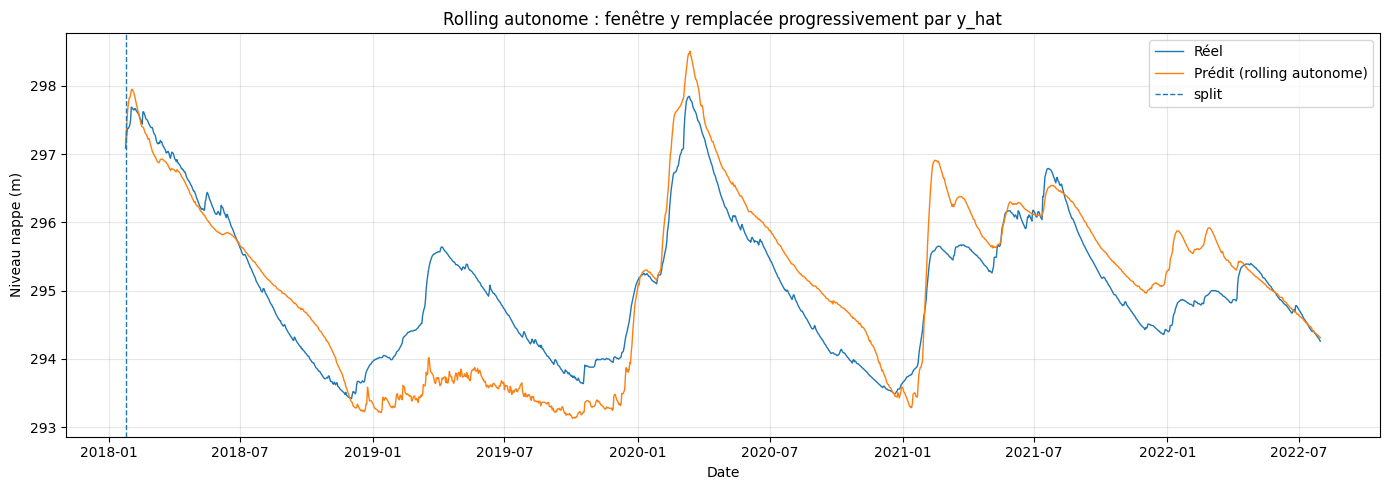

In [17]:
# =========================
# Rolling AUTONOME : la fenêtre de 30 y est progressivement remplacée par y_hat
# Entrée à t : [y_hist(30), exog(t)]
# y_hist initial = 30 vrais avant split
# =========================

model.eval()

# dates de test = à partir de split_raw
test_dates = df.index[split_raw:]
y_true_test = df[target].loc[test_dates].values.astype(np.float32)

# init fenêtre y_hist avec les 30 derniers vrais AVANT split
y_hist = df[target].iloc[split_raw - Y_WINDOW:split_raw].values.astype(np.float32).tolist()
assert len(y_hist) == Y_WINDOW

y_pred_roll = np.zeros(len(test_dates), dtype=np.float32)

for i, d in enumerate(test_dates):
    # exogs du jour d
    x_t = df.loc[d, exog_features].values.astype(np.float32)

    # construire la séquence (Y_WINDOW+1, N_IN)
    seq = np.zeros((Y_WINDOW + 1, N_IN), dtype=np.float32)

    # tokens y_hist (à scaler)
    seq[:Y_WINDOW, 0] = np.array(y_hist, dtype=np.float32)

    # token exog (à scaler)
    seq[Y_WINDOW, 1:] = x_t

    # appliquer les mêmes scalers que training
    seq_scaled = seq.copy()

    # scale y_hist via sc_y
    seq_scaled[:Y_WINDOW, 0] = sc_y.transform(seq_scaled[:Y_WINDOW, 0].reshape(-1,1)).reshape(-1)

    # scale exog via sc_x
    seq_scaled[Y_WINDOW, 1:] = sc_x.transform(seq_scaled[Y_WINDOW, 1:].reshape(1,-1)).reshape(-1)

    # prédire
    xt = torch.from_numpy(seq_scaled).unsqueeze(0).to(device)  # (1, Y_WINDOW+1, N_IN)
    with torch.no_grad():
        y_hat_s = model(xt).cpu().numpy()  # scaled (1,1)

    y_hat = float(sc_y.inverse_transform(y_hat_s)[0,0])
    y_pred_roll[i] = y_hat

    # mise à jour fenêtre: on décale et on injecte y_hat
    y_hist.pop(0)
    y_hist.append(y_hat)

# métriques rolling autonome
rmse_roll = np.sqrt(mean_squared_error(y_true_test, y_pred_roll))
mae_roll  = mean_absolute_error(y_true_test, y_pred_roll)
r2_roll   = r2_score(y_true_test, y_pred_roll)

print(f"[ROLLING AUTONOME y_window={Y_WINDOW}] RMSE: {rmse_roll:.4f} | MAE: {mae_roll:.4f} | R2: {r2_roll:.4f}")

# plot
plt.figure(figsize=(14,5))
plt.plot(test_dates, y_true_test, linewidth=1, label="Réel")
plt.plot(test_dates, y_pred_roll, linewidth=1, label="Prédit (rolling autonome)")
plt.axvline(df.index[split_raw], linestyle="--", linewidth=1, label="split")
plt.title("Rolling autonome : fenêtre y remplacée progressivement par y_hat")
plt.xlabel("Date"); plt.ylabel("Niveau nappe (m)")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()
